# Exploratory Data Analysis

Let's play!

In [72]:
# Install additional packages
!python -m pip install seaborn
!python -m pip install xgboost
!python -m pip install m2cgen
!python -m pip install treelite
!python -m pip install treelite_runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.8/922.8 kB 336.5 kB/s eta 0:00:00a 0:00:01


In [74]:
import os

import keras
import matplotlib.pyplot as plt
import m2cgen as m2c
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import torch
import treelite
import treelite_runtime
from xgboost import XGBRegressor

In [3]:
# Settings
DATA_PATH = "data/sg92r/force"
SEED = 42
VAL_SPLIT = 0.2
TEST_SPLIT = 0.2
NO_FORCE_PREFIX = "0mm"
MAX_POT = 3.3
MODEL_PATH = "models/sg92r"

## Initial Exploration (Correlation)

In [4]:
# Get files in the data directory
csv_files = os.listdir(DATA_PATH)

# Shuffle list of files
rng = np.random.default_rng(seed=SEED)
rng.shuffle(csv_files)

# Split files into train, validation, and test sets
num_files = len(csv_files)
num_val_files = int(num_files * VAL_SPLIT)
num_test_files = int(num_files * TEST_SPLIT)
val_files = csv_files[:num_val_files]
test_files = csv_files[num_val_files:num_val_files + num_test_files]
train_files = csv_files[num_val_files + num_test_files:]

# Print split information
print(f"Total files: {num_files}")
print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

Total files: 2400
Train files: 1440
Validation files: 480
Test files: 480


In [5]:
# Load data
def load_csv_files(files):
    df_list = []
    for file in files:
        df_list.append(pd.read_csv(os.path.join(DATA_PATH, file)))
    return pd.concat(df_list, ignore_index=True)

# Build dataframes
df_train = load_csv_files(train_files)
df_val = load_csv_files(val_files)
df_test = load_csv_files(test_files)

# Remove leading and trailing whitespaces from column names
df_train.columns = df_train.columns.str.strip()
df_val.columns = df_val.columns.str.strip()
df_test.columns = df_test.columns.str.strip()

# Get columns from dataframe
columns = df_train.columns
print(columns)

Index(['Timestamp', 'Desired Position', 'Servo Current', 'Servo Voltage',
       'Servo Potentiometer', 'Encoder', 'Force'],
      dtype='object')


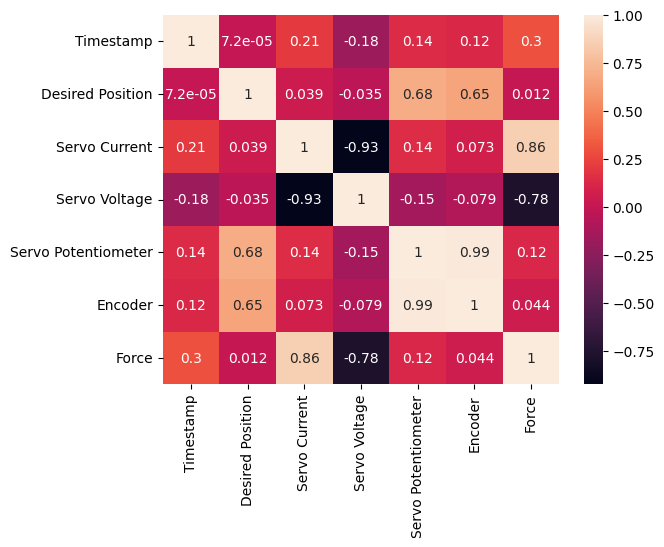

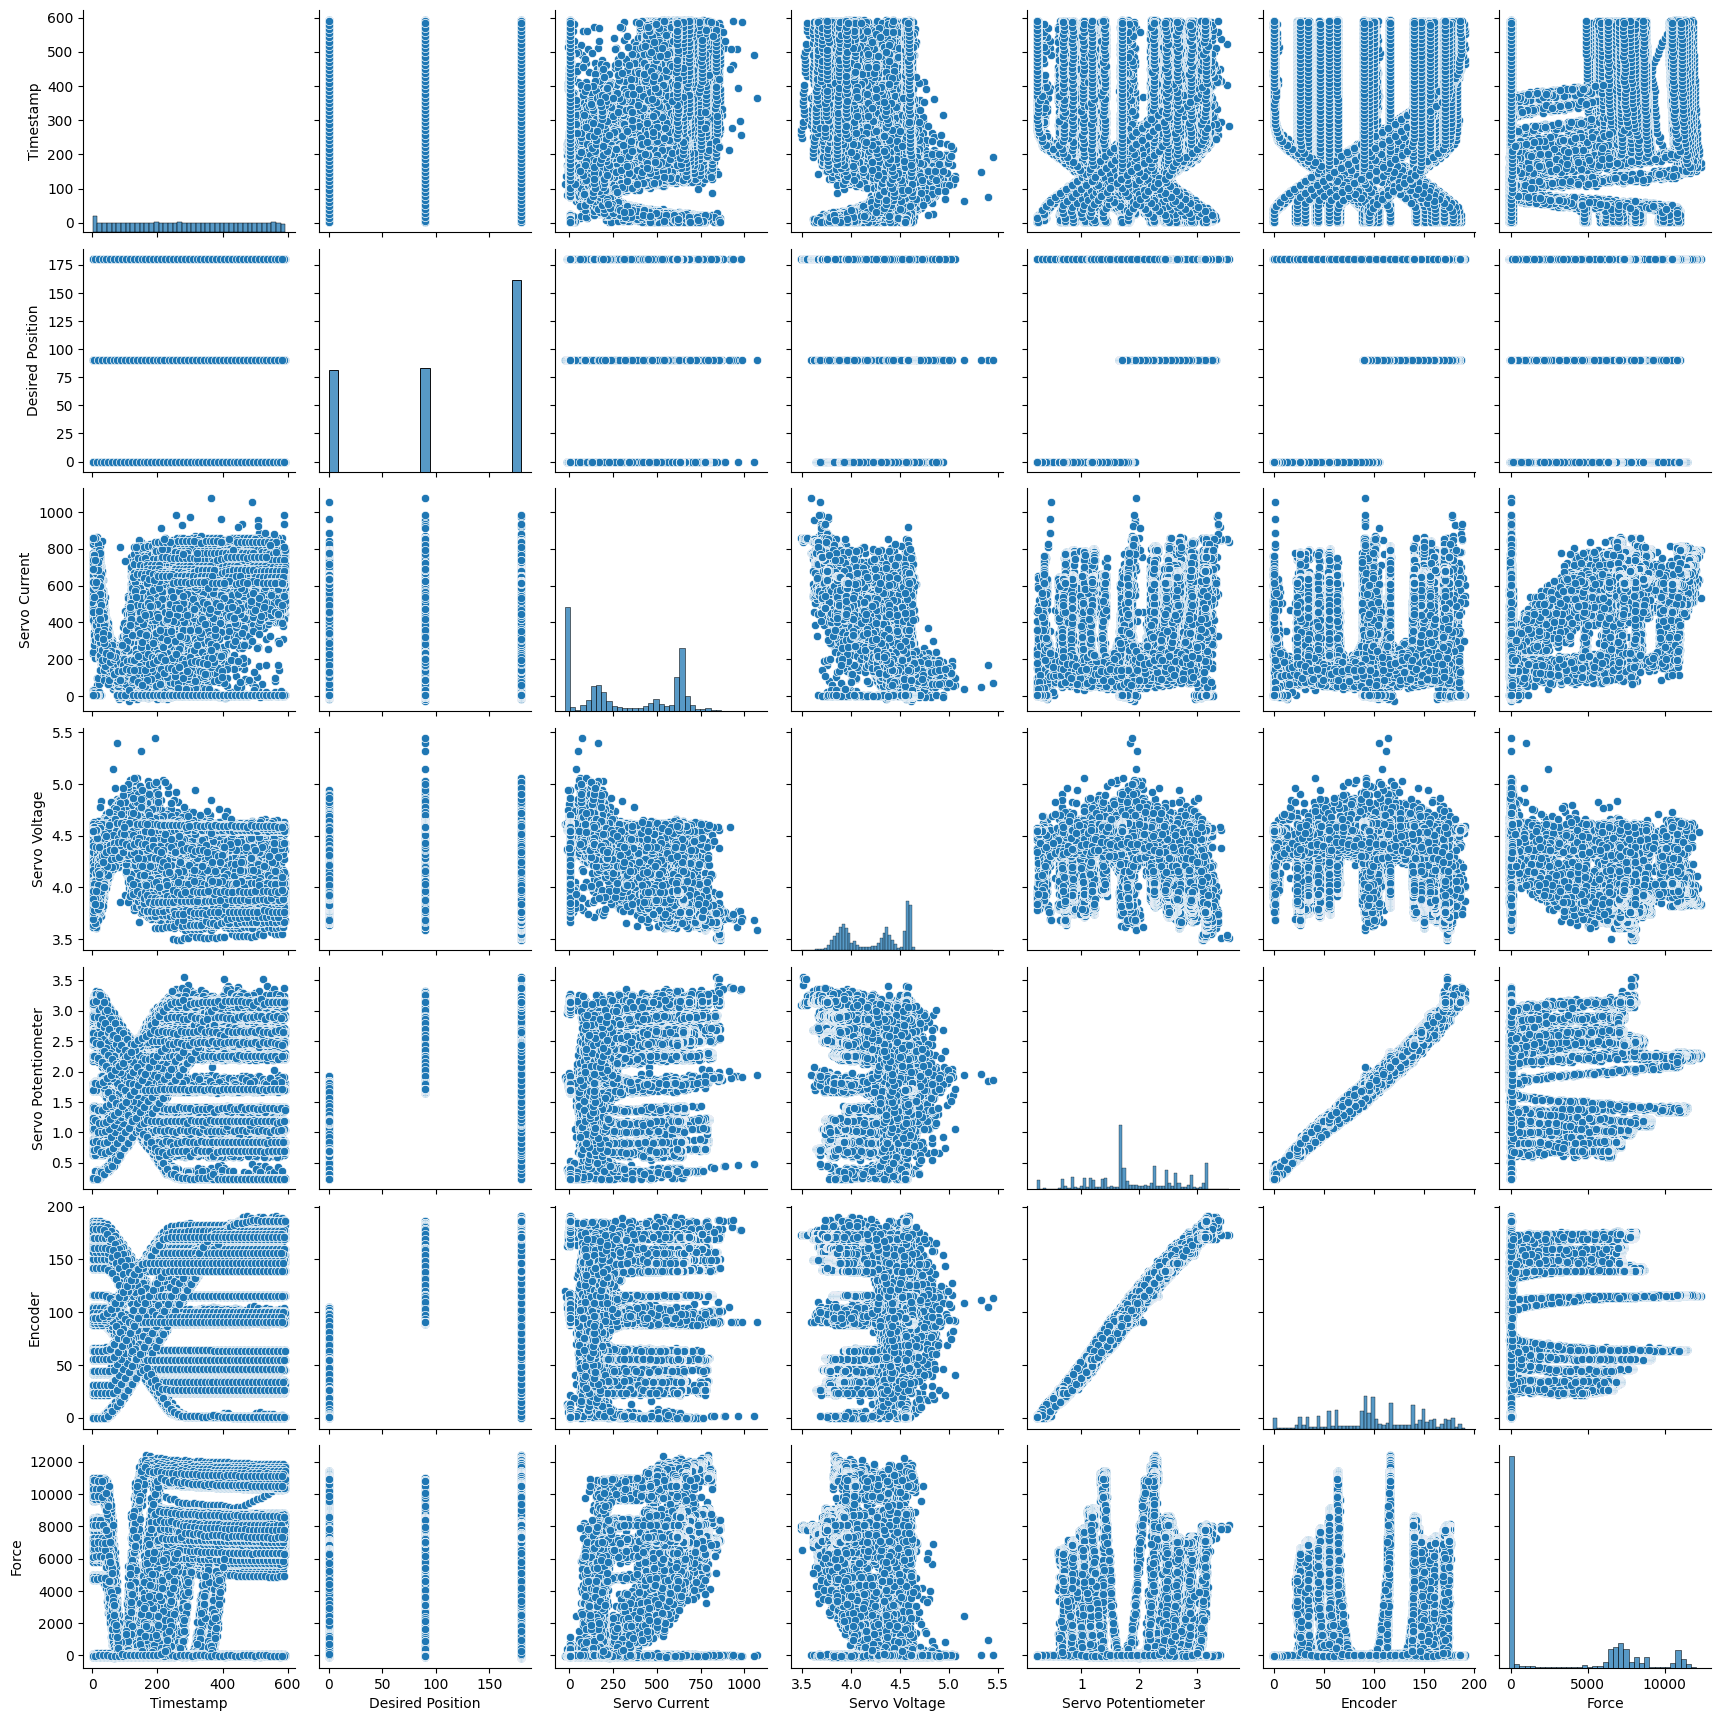

In [6]:
# Create correlation plots
sns.heatmap(df_train[columns].corr(), annot=True)
sns.pairplot(df_train[columns])

In [7]:
# Clone dataframes
df_pos_train = df_train.copy()
df_pos_val = df_val.copy()
df_pos_test = df_test.copy()

# Create a column that is delta timestamp
df_pos_train['delta_time'] = df_train['Timestamp'].diff()
df_pos_val['delta_time'] = df_val['Timestamp'].diff()
df_pos_test['delta_time'] = df_test['Timestamp'].diff()

# Drop rows with NaN values
df_pos_train.dropna(inplace=True)
df_pos_val.dropna(inplace=True)
df_pos_test.dropna(inplace=True)

# Drop timestamp, desired position, and servo voltage columns
df_pos_train.drop(columns=['Timestamp', 'Desired Position', 'Servo Voltage'], inplace=True)
df_pos_val.drop(columns=['Timestamp', 'Desired Position', 'Servo Voltage'], inplace=True)
df_pos_test.drop(columns=['Timestamp', 'Desired Position', 'Servo Voltage'], inplace=True)

# Get new columns from dataframe
columns = df_pos_train.columns
print(columns)

Index(['Servo Current', 'Servo Potentiometer', 'Encoder', 'Force',
       'delta_time'],
      dtype='object')


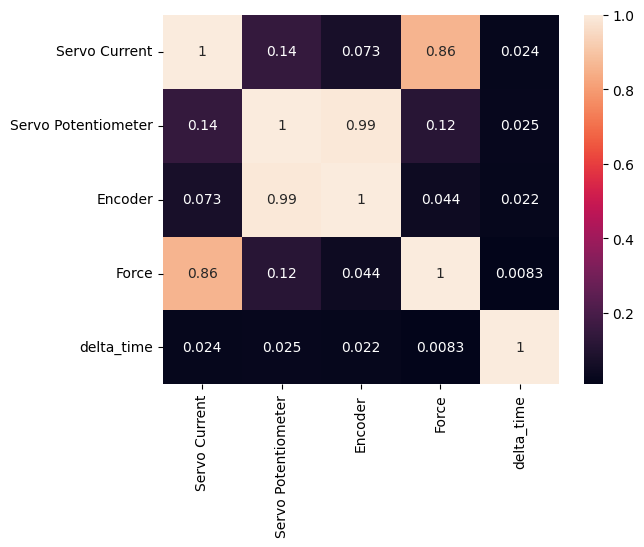

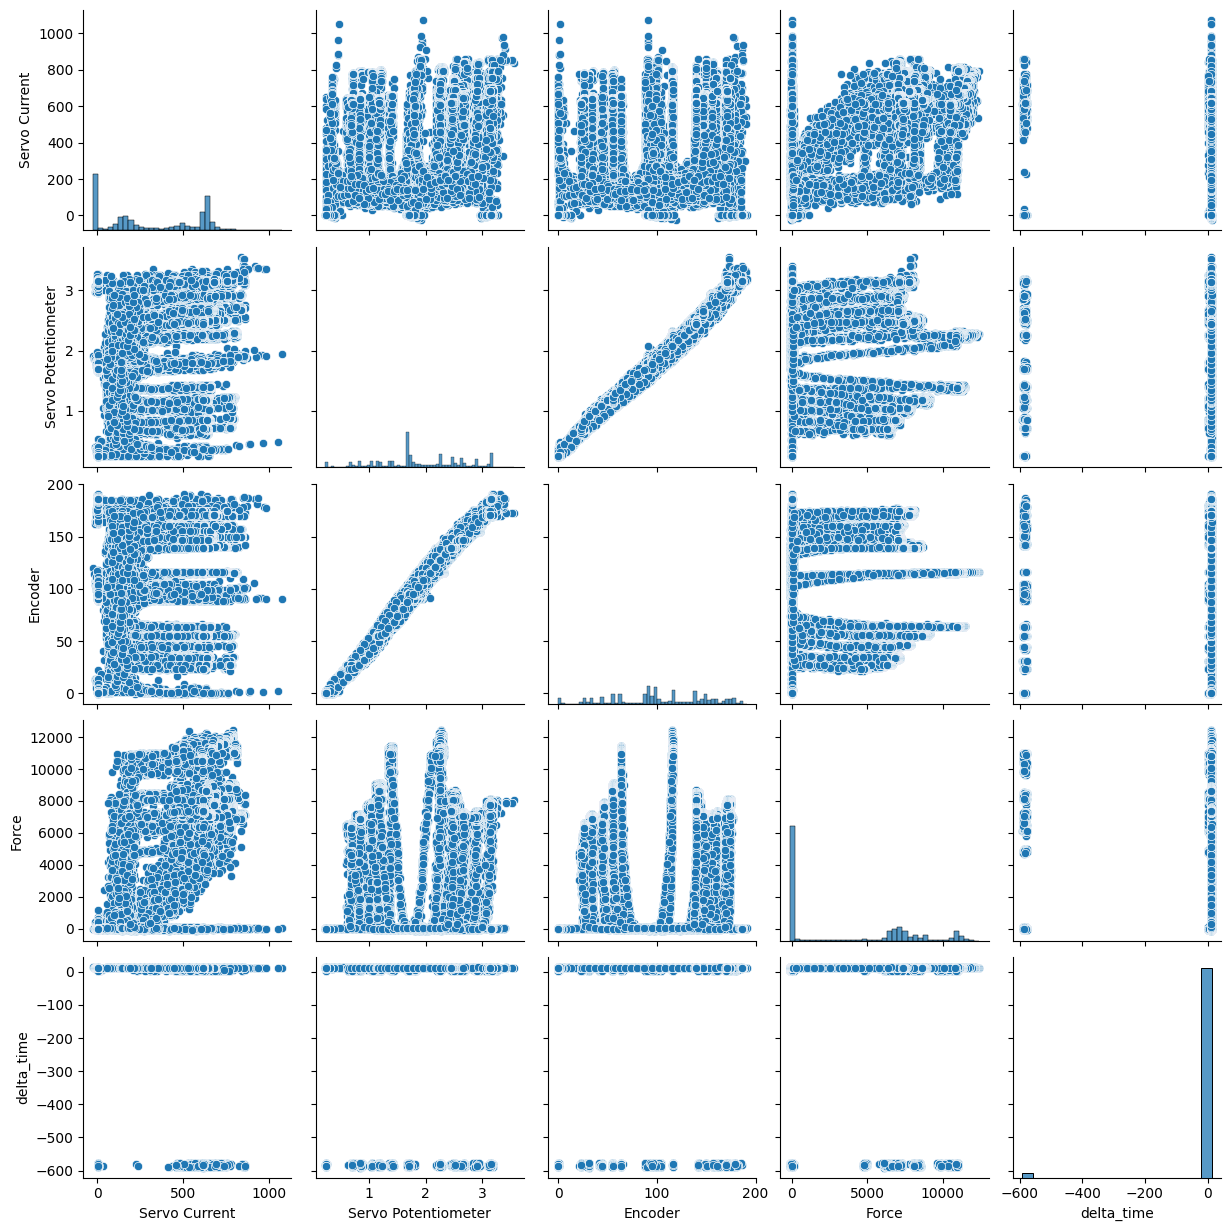

In [8]:
# Create correlation plots
sns.heatmap(df_pos_train[columns].corr(), annot=True)
sns.pairplot(df_pos_train[columns])


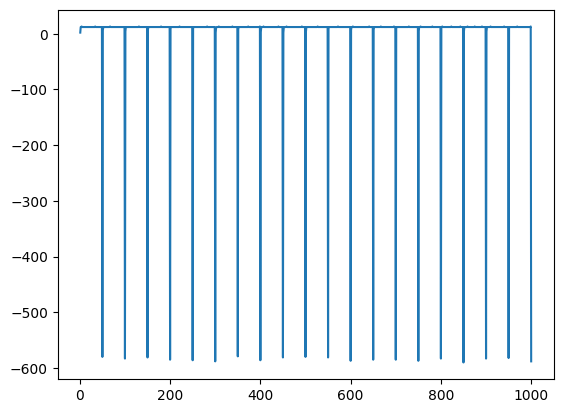

In [9]:
# Plot delta time over time (heads up: includes space between files)
plt.plot(df_pos_train['delta_time'][0:1000])

## Try Linear Regression Model for Position Estimation

In [10]:
# Train model
X_train = df_train[['Servo Potentiometer']]
y_train = df_train['Encoder']
model = LinearRegression()
model.fit(X_train, y_train)

# Validate model
X_val = df_val[['Servo Potentiometer']]
y_val = df_val['Encoder']
y_val_pred = model.predict(X_val)

# Calculate mean squared error
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean squared error (val): {mse}")

Mean squared error (val): 36.76752051016707


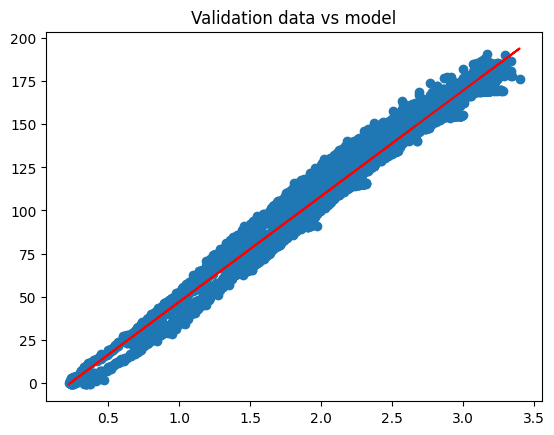

In [11]:
# Plot line vs actual values
plt.scatter(X_val, y_val)
plt.plot(X_val, y_val_pred, color='red')
plt.title('Validation data vs model')
plt.show()

## Stall Estimation Exploration

In [12]:
# Plot positional differences
def plot_pos_diffs(files):

    # Get file paths
    file_paths = [os.path.join(DATA_PATH, file) for file in files]
    
    # List of position differences
    dpos_list = []

    # Read in data from files
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip()
        dpos = abs(df['Desired Position'] - df['Encoder'])
        dpos_list.append(dpos)

    # Plot position differences with legend
    for dpos in dpos_list:
        plt.plot(dpos)
    plt.legend(files)

In [13]:
# Plot servo current over time
def plot_current(files):

    # Get file paths
    file_paths = [os.path.join(DATA_PATH, file) for file in files]
    
    # List of servo currents
    current_list = []

    # Read in data from files
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip()
        current = df['Servo Current']
        current_list.append(current)

    # Plot servo current with legend
    for current in current_list:
        plt.plot(current)
    plt.legend(files)

In [14]:
# Plot voltage over time
def plot_voltage(files):

    # Get file paths
    file_paths = [os.path.join(DATA_PATH, file) for file in files]
    
    # List of servo voltages
    voltage_list = []

    # Read in data from files
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip()
        voltage = df['Servo Voltage']
        voltage_list.append(voltage)

    # Plot servo voltage with legend
    for voltage in voltage_list:
        plt.plot(voltage)
    plt.legend(files)

In [15]:
# Plot force
def plot_force(files):

    # Get file paths
    file_paths = [os.path.join(DATA_PATH, file) for file in files]
    
    # List of forces
    force_list = []

    # Read in data from files
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip()
        force = df['Force']
        force_list.append(force)

    # Plot force with legend
    for force in force_list:
        plt.plot(force)
    plt.legend(files)

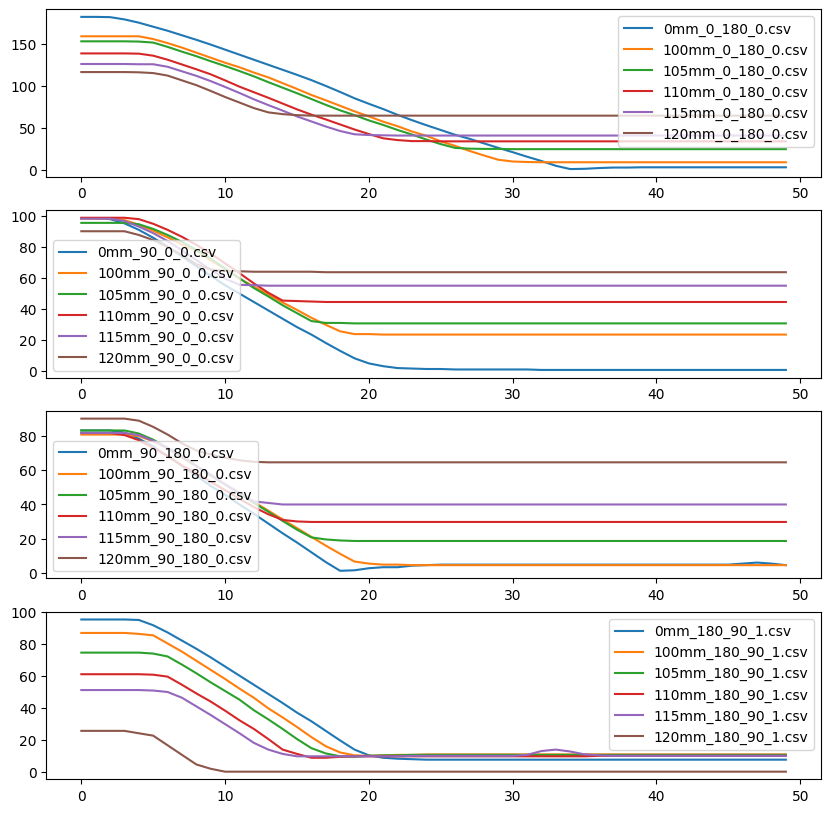

In [16]:
# List of files to test
file_lists = [[
      '0mm_0_180_0.csv',
    '100mm_0_180_0.csv',
    '105mm_0_180_0.csv',
    '110mm_0_180_0.csv',
    '115mm_0_180_0.csv',
    '120mm_0_180_0.csv',
],
[
      '0mm_90_0_0.csv',
    '100mm_90_0_0.csv',
    '105mm_90_0_0.csv',
    '110mm_90_0_0.csv',
    '115mm_90_0_0.csv',
    '120mm_90_0_0.csv',
],
[
      '0mm_90_180_0.csv',
    '100mm_90_180_0.csv',
    '105mm_90_180_0.csv',
    '110mm_90_180_0.csv',
    '115mm_90_180_0.csv',
    '120mm_90_180_0.csv',
],
[
      '0mm_180_90_1.csv',
    '100mm_180_90_1.csv',
    '105mm_180_90_1.csv',
    '110mm_180_90_1.csv',
    '115mm_180_90_1.csv',
    '120mm_180_90_1.csv',
]]

# Plot positional differences on subplots
fig, axs = plt.subplots(len(file_lists), 1, figsize=(10, 10))
for i, file_list in enumerate(file_lists):
    plt.sca(axs[i])
    plot_pos_diffs(file_list)

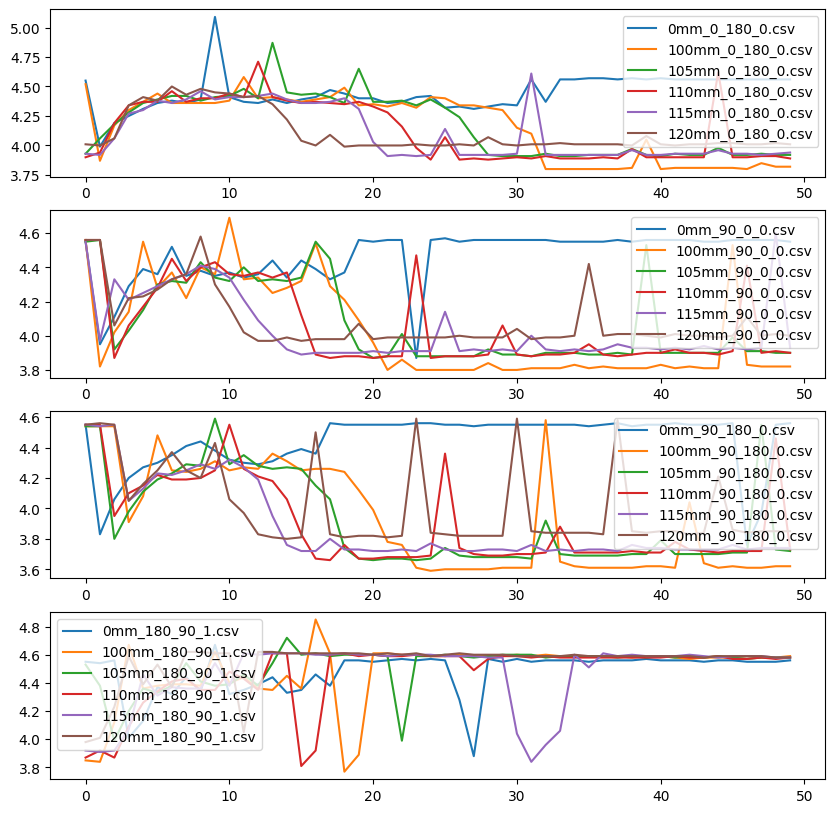

In [17]:
# Plot voltage on subplots
fig, axs = plt.subplots(len(file_lists), 1, figsize=(10, 10))
for i, file_list in enumerate(file_lists):
    plt.sca(axs[i])
    plot_voltage(file_list)

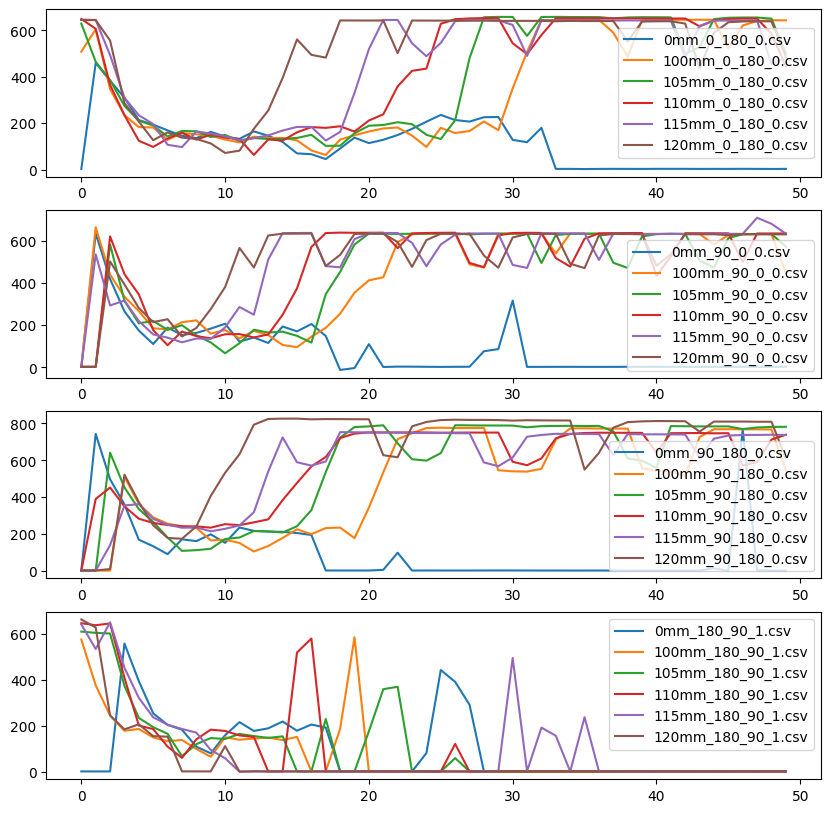

In [18]:
# Plot current on subplots
fig, axs = plt.subplots(len(file_lists), 1, figsize=(10, 10))
for i, file_list in enumerate(file_lists):
    plt.sca(axs[i])
    plot_current(file_list)

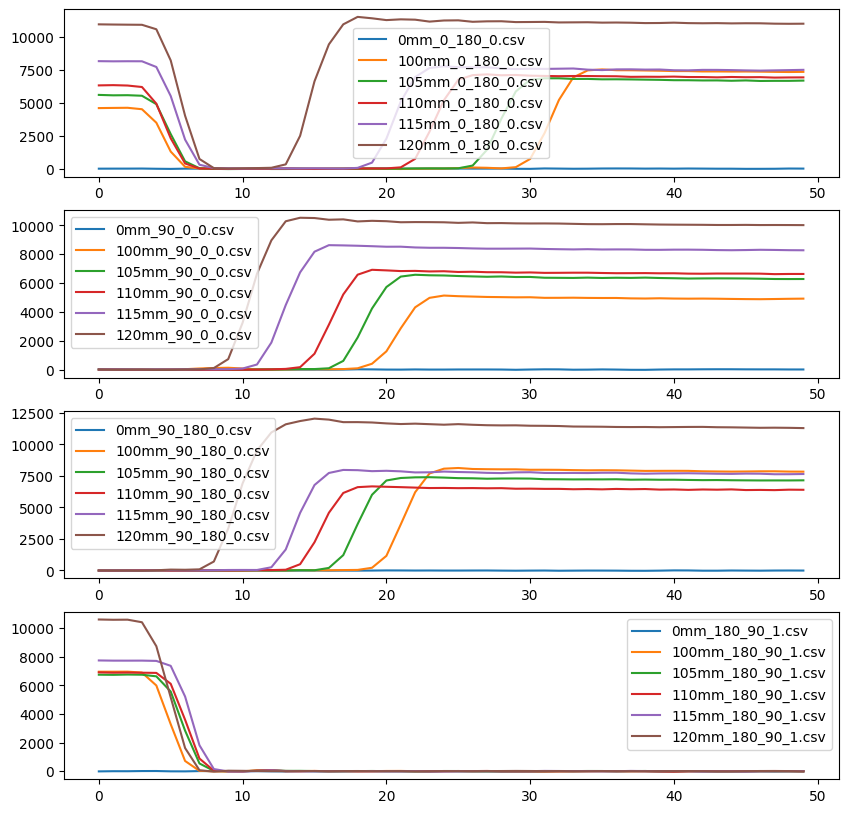

In [19]:
# Plot force on subplots
# Plot on subplots
fig, axs = plt.subplots(len(file_lists), 1, figsize=(10, 10))
for i, file_list in enumerate(file_lists):
    plt.sca(axs[i])
    plot_force(file_list)

In [20]:
# Normalize
def normalize(val):
    return (val - val.min()) / (val.max() - val.min())

In [21]:
# Plot normalized force
def plot_normalized_force(files):
    
    # List of forces
    force_list = []

    # Read in data from files
    for file in files:

        # Read force column
        df = pd.read_csv(os.path.join(DATA_PATH, file))
        df.columns = df.columns.str.strip()
        force = normalize(df['Force'])

        # If file prefix is 0mm, set force to 0
        if file.startswith('0mm'):
            force = np.zeros(len(force))

        # Append force to list
        force_list.append(force)

    # Normalize forces
    for force in force_list:
        plt.plot(force)
    plt.legend(files)

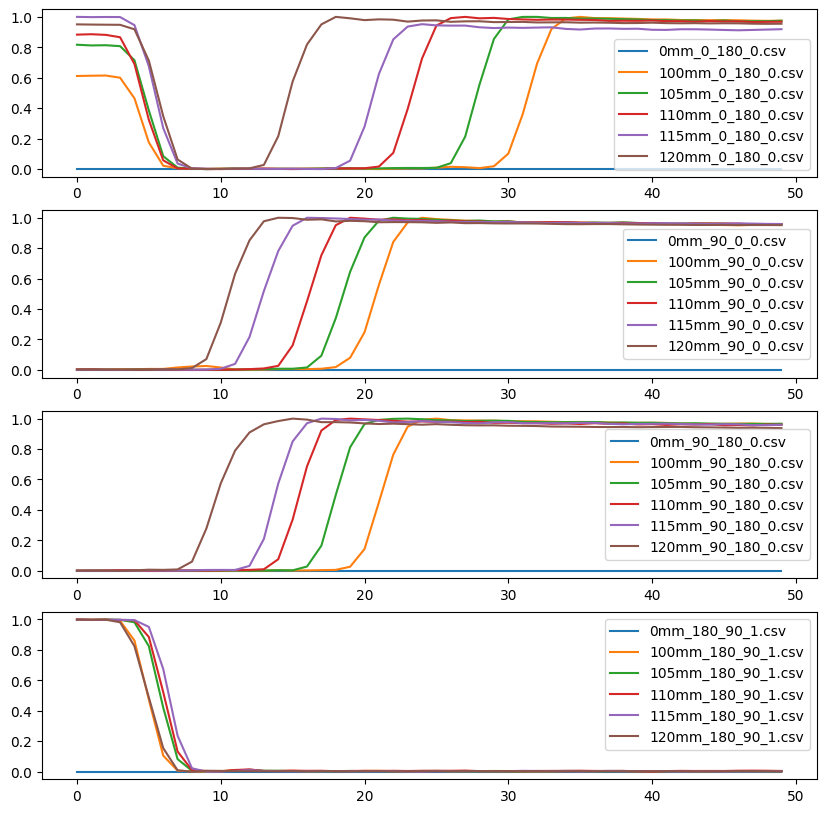

In [22]:
# Plot normalized force on subplots
fig, axs = plt.subplots(len(file_lists), 1, figsize=(10, 10))
for i, file_list in enumerate(file_lists):
    plt.sca(axs[i])
    plot_normalized_force(file_list)

## Create Dataset

In [23]:
# Get files in the data directory
csv_files = os.listdir(DATA_PATH)

# Shuffle list of files
rng = np.random.default_rng(seed=SEED)
rng.shuffle(csv_files)

# Split files into train, validation, and test sets
num_files = len(csv_files)
num_val_files = int(num_files * VAL_SPLIT)
num_test_files = int(num_files * TEST_SPLIT)
val_files = csv_files[:num_val_files]
test_files = csv_files[num_val_files:num_val_files + num_test_files]
train_files = csv_files[num_val_files + num_test_files:]

# Print split information
print(f"Total files: {num_files}")
print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

Total files: 2400
Train files: 1440
Validation files: 480
Test files: 480


In [24]:
# Load data and modify dataframes
def load_and_modify_data(files):

    # Create list of dataframes from CSV files
    df_list = []
    for file in files:

        # Read CSV file and strip column names
        df = pd.read_csv(os.path.join(DATA_PATH, file))
        df.columns = df.columns.str.strip()

        # Create a "stall" column
        force = normalize(df['Force'])
        if file.startswith(NO_FORCE_PREFIX):
            force = np.zeros(len(force))
        df['Stall'] = force

        # Creata a "delta time" column (seconds)
        df['Delta Time'] = df['Timestamp'].diff() / 1000

        # Normalize the potentiometer readings
        df['Norm Potentiometer'] = df['Servo Potentiometer'] / MAX_POT

        # Create a "position derivative" column
        df['Derivative Potentiometer'] = df['Norm Potentiometer'].diff() / df['Delta Time']

        # Create a "current derivative" column
        df['Derivative Current'] = df['Servo Current'].diff() / df['Delta Time']

        # Create sin and cos columns (1.0 = 180 degrees)
        df['Sin Potentiometer'] = np.sin(df['Norm Potentiometer'] * np.pi)
        df['Cos Potentiometer'] = np.cos(df['Norm Potentiometer'] * np.pi)

        # Create multiplication columns
        df['Current * Potentiometer'] = df['Servo Current'] * df['Norm Potentiometer']

        # Clean up the dataframe (drop NaN values and columns)
        df.dropna(inplace=True)

        # Drop columns
        df.drop(columns=[
            'Timestamp', 
            'Servo Voltage', 
            'Encoder', 
            'Force', 
            'Servo Potentiometer'
        ], inplace=True)
        
        # Append dataframe to list
        df_list.append(df)

    return pd.concat(df_list, ignore_index=True)

In [25]:
# Build dataframes (and randomize row orders)
df_train = load_and_modify_data(train_files).sample(frac=1)
df_val = load_and_modify_data(val_files).sample(frac=1)
df_test = load_and_modify_data(test_files).sample(frac=1)

# Get column names from dataframe
columns = df_train.columns
print(columns)

Index(['Desired Position', 'Servo Current', 'Stall', 'Delta Time',
       'Norm Potentiometer', 'Derivative Potentiometer', 'Derivative Current',
       'Sin Potentiometer', 'Cos Potentiometer', 'Current * Potentiometer'],
      dtype='object')


In [26]:
df_train.head()

Desired Position  Servo Current     Stall  Delta Time  \
37633             180.0          441.0  0.001131       0.012   
66338              90.0            3.0  0.002132       0.012   
68416               0.0          660.7  0.933309       0.012   
51668               0.0          634.7  0.975639       0.012   
57247               0.0          141.2  0.000000       0.012   

       Norm Potentiometer  Derivative Potentiometer  Derivative Current  \
37633            0.545455                  2.525253        36525.000000   
66338            0.515152                  0.000000            0.000000   
68416            0.424242                 -0.252525           41.666667   
51668            0.424242                  1.010101        12816.666667   
57247            0.200000                 -2.777778        -5558.333333   

       Sin Potentiometer  Cos Potentiometer  Current * Potentiometer  
37633           0.989821          -0.142315               240.545455  
66338           0.998867          -0.047582                 1.545455  
68416           0.971812           0.235759               280.296970  
51668           0.971812           0.235759               269.266667  
57247           0.587785           0.809017                28.240000

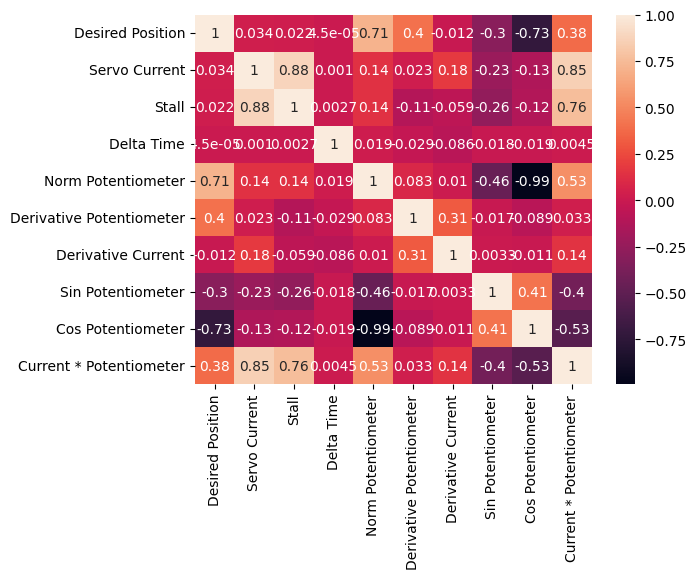

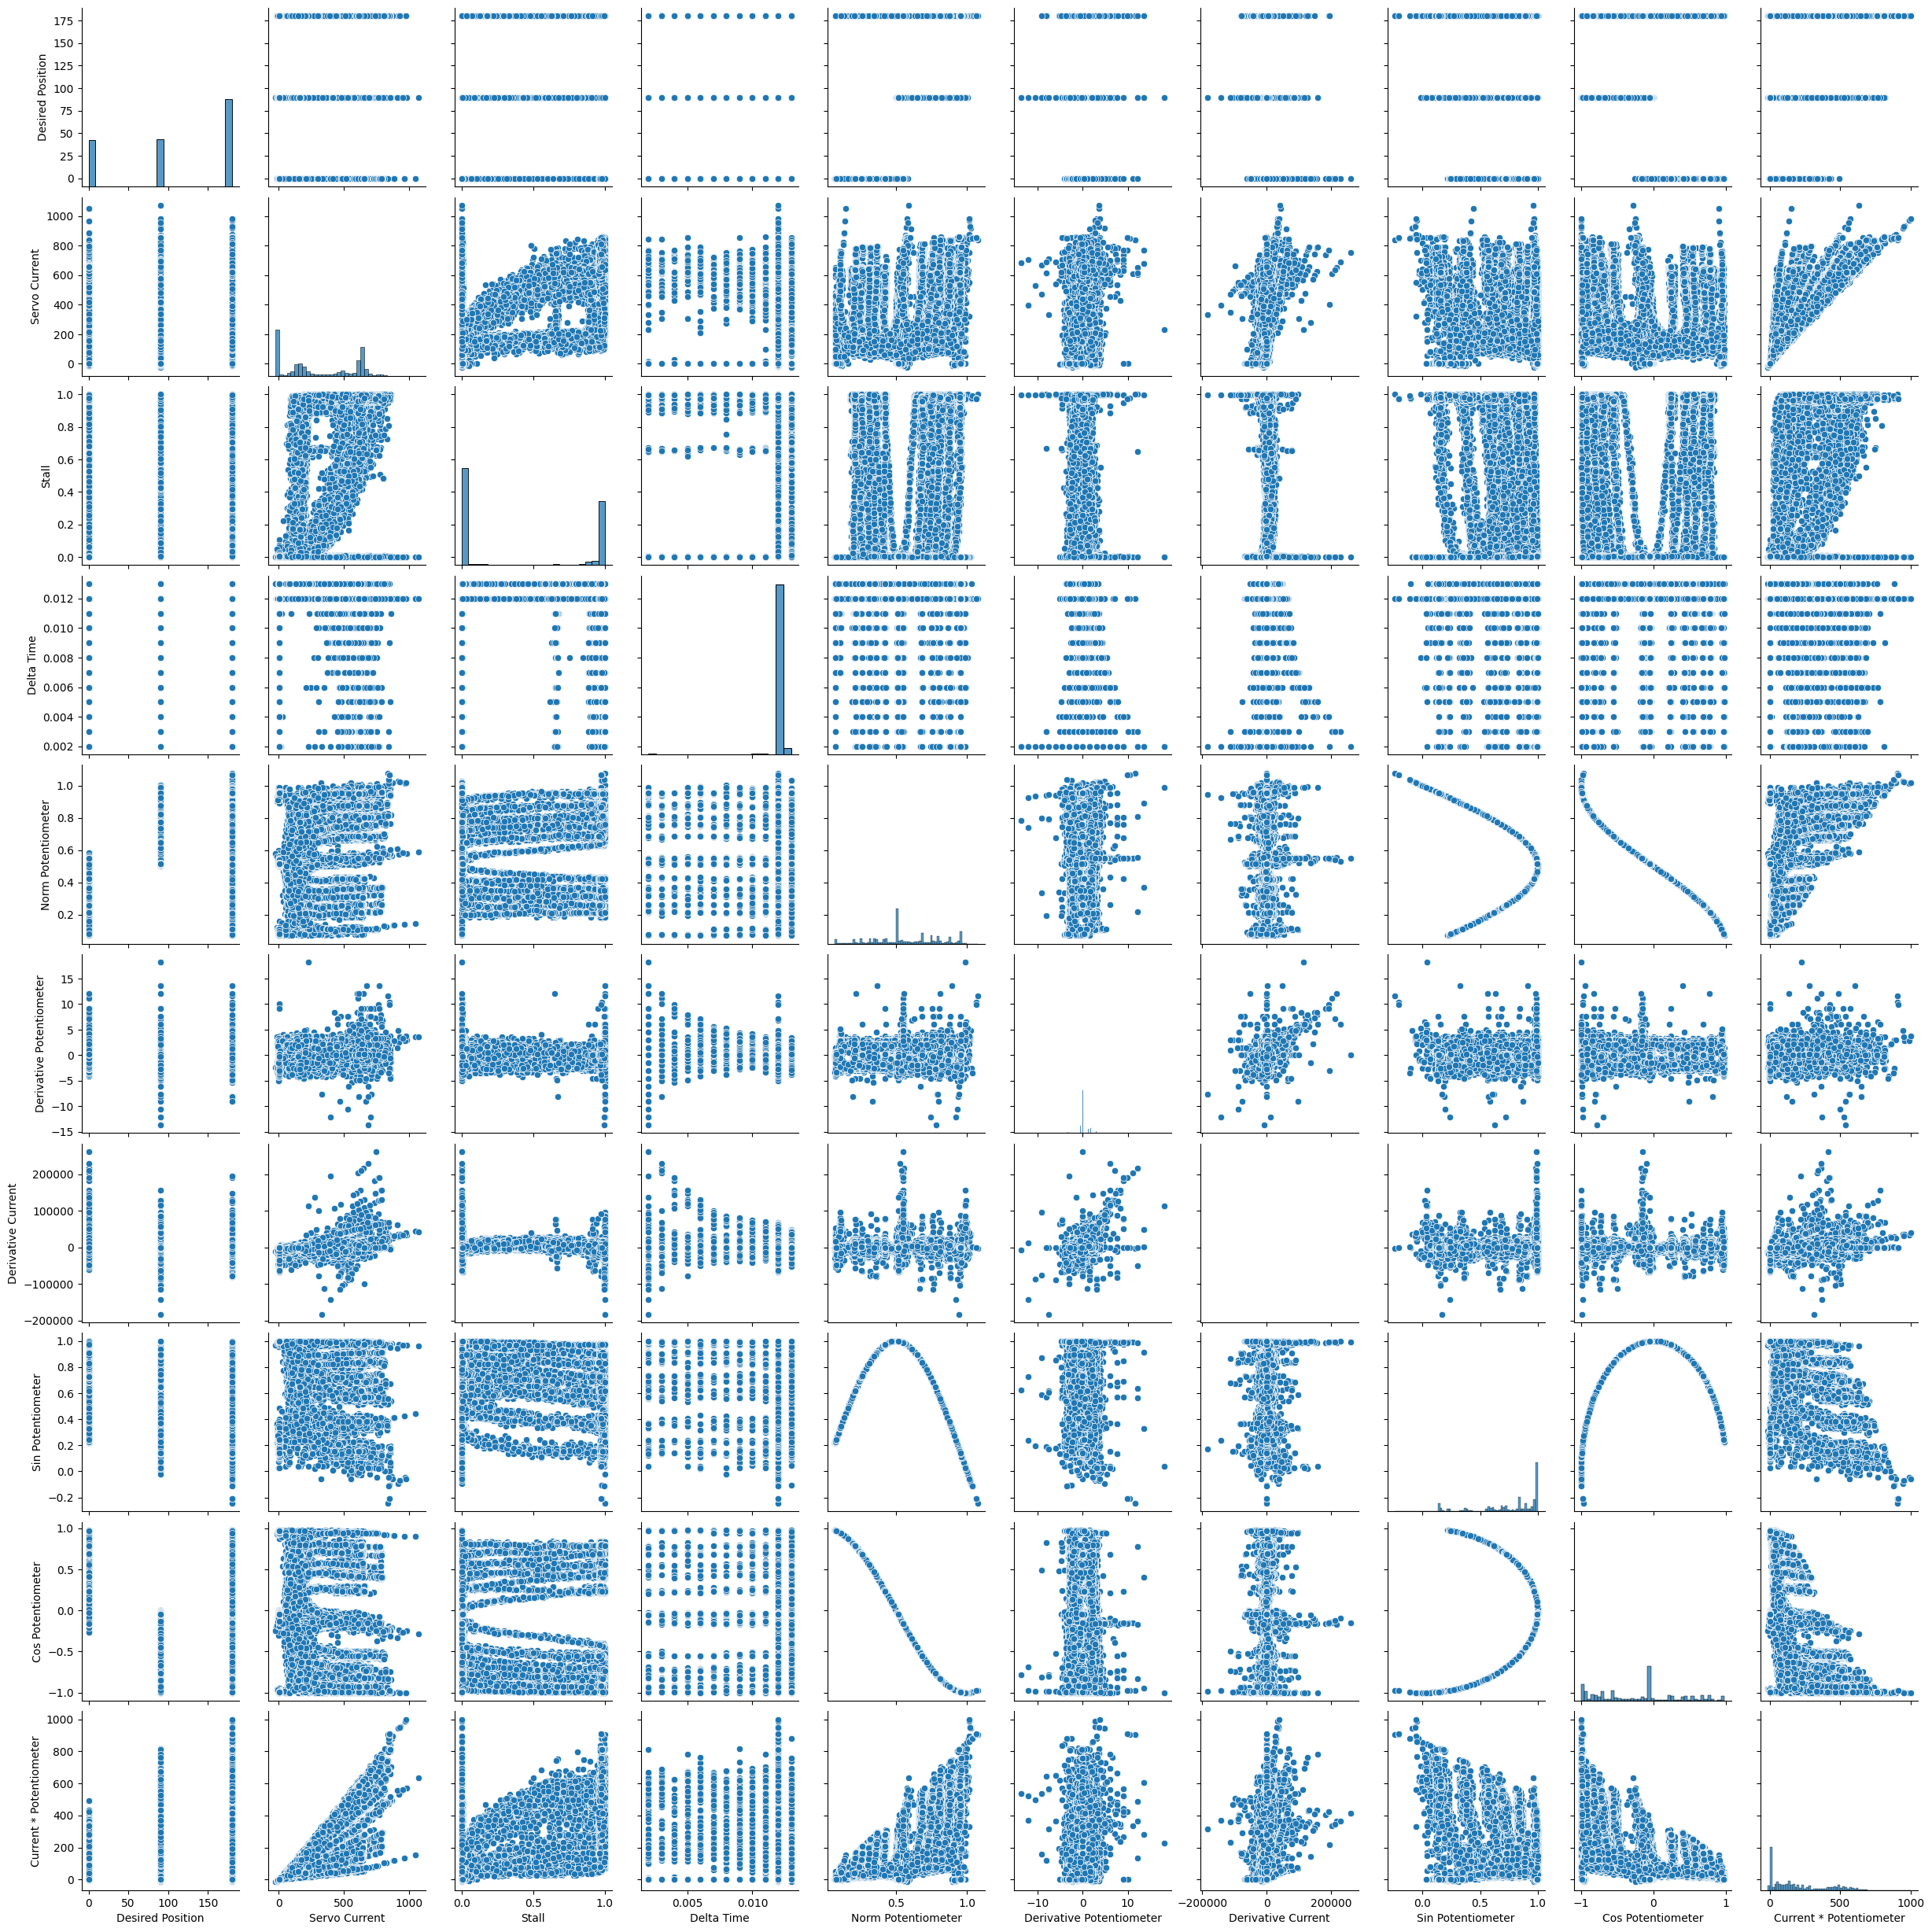

In [27]:
# Create correlation plots
sns.heatmap(df_train[columns].corr(), annot=True)
sns.pairplot(df_train[columns])

In [28]:
# X and y columns
X_cols = [
    'Servo Current',
    'Norm Potentiometer',
    'Derivative Current',
    'Sin Potentiometer',
]
y_cols = ['Stall']

# Create X dataframes
X_train = df_train[X_cols]
X_val = df_val[X_cols]
X_test = df_test[X_cols]

# Create y dataframes
y_train = df_train[y_cols]
y_val = df_val[y_cols]
y_test = df_test[y_cols]

## Model Exploration: Linear Regression

In [29]:
# Train regression model
model = LinearRegression()
model.fit(X_train, y_train)
score_train = model.score(X_train, y_train)
print(f"Score (train): {score_train}")
print(model.coef_)
print(model.intercept_)

Score (train): 0.8305490622735155
[[ 1.57609054e-03 -3.84635290e-02 -1.04535588e-05 -1.04018860e-01]]
[0.0110586]


In [30]:
# Validate model and calculate mean squared error
score = model.score(X_val, y_val)
y_val_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
print(f"Score (val): {score}")
print(f"Mean squared error (val): {mse}")


Score (val): 0.8269429321395126
Mean squared error (val): 0.038387020431628116


## Model Exploration: DNN

In [31]:
# Set default devcice
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
# Create simple neural network
inputs = keras.Input(shape=(len(X_cols),))
x1 = keras.layers.Dense(16, activation="relu")(inputs)
x2 = keras.layers.Dense(8, activation="relu")(x1)
output = keras.layers.Dense(1)(x2)
model = keras.Model(inputs=inputs, outputs=output)

# Compile model
model.compile(optimizer="adam", loss="mean_squared_error")
model.to(device)

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Copy data to device
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)

In [34]:
# Train model
history = model.fit(
    X_train_tensor, 
    y_train_tensor, 
    validation_data=(X_val_tensor, y_val_tensor), 
    epochs=10, 
    batch_size=128
)

Epoch 1/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3883304.2500 - val_loss: 47.0596
Epoch 2/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 30.6589 - val_loss: 17.4136
Epoch 3/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 14.4781 - val_loss: 11.0666
Epoch 4/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.8041 - val_loss: 8.5286
Epoch 5/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.9700 - val_loss: 7.1378
Epoch 6/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.4253 - val_loss: 5.7769
Epoch 7/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.0807 - val_loss: 6.3057
Epoch 8/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.9144 - val_loss: 3.7019
Epoch 9/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.2573 - val_loss: 3.0104
Epoch 10/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.4036 - val_loss: 1.1038


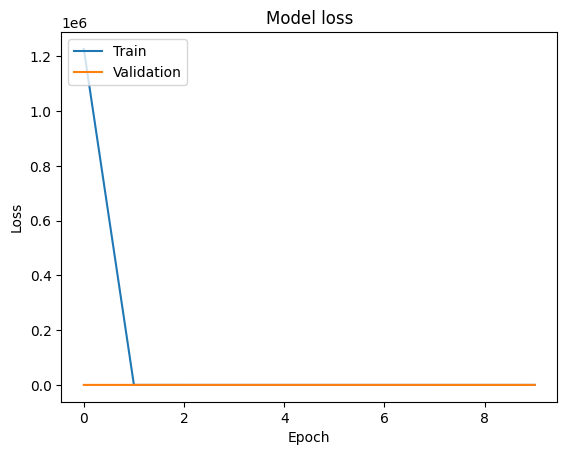

In [35]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Time Windowing

In [36]:
# Settings
READINGS_PER_SAMPLE = 3

In [37]:
# Build dataframes
df_train = load_and_modify_data(train_files)
df_val = load_and_modify_data(val_files)
df_test = load_and_modify_data(test_files)

# Get column names from dataframe
columns = df_train.columns
print(columns)

Index(['Desired Position', 'Servo Current', 'Stall', 'Delta Time',
       'Norm Potentiometer', 'Derivative Potentiometer', 'Derivative Current',
       'Sin Potentiometer', 'Cos Potentiometer', 'Current * Potentiometer'],
      dtype='object')


In [38]:
# Create windowed dataframes
def create_windowed_data(df, readings_per_sample):

    # Create a list of dataframes
    df_list = []

    # Create a windowed dataframe
    for i in range(len(df) - readings_per_sample):
        df_window = df[i:i + readings_per_sample].copy()
        df_window.reset_index(drop=True, inplace=True)
        df_list.append(df_window)

    return pd.concat(df_list, ignore_index=True)

In [39]:
# Create windowed dataframes
df_train_windowed = create_windowed_data(df_train, READINGS_PER_SAMPLE)
df_val_windowed = create_windowed_data(df_val, READINGS_PER_SAMPLE)
df_test_windowed = create_windowed_data(df_test, READINGS_PER_SAMPLE)

# Print length of windowed dataframes
print(len(df_train_windowed))

211671


In [40]:
df_train_windowed.head(20)

Desired Position  Servo Current  Stall  Delta Time  Norm Potentiometer  \
0               90.0            3.0    0.0       0.002            0.954545   
1               90.0          632.2    0.0       0.012            0.990909   
2               90.0          409.5    0.0       0.012            0.957576   
3               90.0          632.2    0.0       0.012            0.990909   
4               90.0          409.5    0.0       0.012            0.957576   
5               90.0          292.2    0.0       0.013            0.924242   
6               90.0          409.5    0.0       0.012            0.957576   
7               90.0          292.2    0.0       0.013            0.924242   
8               90.0          215.0    0.0       0.012            0.887879   
9               90.0          292.2    0.0       0.013            0.924242   
10              90.0          215.0    0.0       0.012            0.887879   
11              90.0          132.9    0.0       0.012            0.857576   
12              90.0          215.0    0.0       0.012            0.887879   
13              90.0          132.9    0.0       0.012            0.857576   
14              90.0          139.9    0.0       0.012            0.833333   
15              90.0          132.9    0.0       0.012            0.857576   
16              90.0          139.9    0.0       0.012            0.833333   
17              90.0          186.9    0.0       0.012            0.812121   
18              90.0          139.9    0.0       0.012            0.833333   
19              90.0          186.9    0.0       0.012            0.812121   

    Derivative Potentiometer  Derivative Current  Sin Potentiometer  \
0                   0.000000         -150.000000           0.142315   
1                   3.030303        52433.333333           0.028556   
2                  -2.777778       -18558.333333           0.132885   
3                   3.030303        52433.333333           0.028556   
4                  -2.777778       -18558.333333           0.132885   
5                  -2.564103        -9023.076923           0.235759   
6                  -2.777778       -18558.333333           0.132885   
7                  -2.564103        -9023.076923           0.235759   
8                  -3.030303        -6433.333333           0.345000   
9                  -2.564103        -9023.076923           0.235759   
10                 -3.030303        -6433.333333           0.345000   
11                 -2.525253        -6841.666667           0.432658   
12                 -3.030303        -6433.333333           0.345000   
13                 -2.525253        -6841.666667           0.432658   
14                 -2.020202          583.333333           0.500000   
15                 -2.525253        -6841.666667           0.432658   
16                 -2.020202          583.333333           0.500000   
17                 -1.767677         3916.666667           0.556559   
18                 -2.020202          583.333333           0.500000   
19                 -1.767677         3916.666667           0.556559   

    Cos Potentiometer  Current * Potentiometer  
0           -0.989821                 2.863636  
1           -0.999592               626.452727  
2           -0.991131               392.127273  
3           -0.999592               626.452727  
4           -0.991131               392.127273  
5           -0.971812               270.063636  
6           -0.991131               392.127273  
7           -0.971812               270.063636  
8           -0.938603               190.893939  
9           -0.971812               270.063636  
10          -0.938603               190.893939  
11          -0.901558               113.971818  
12          -0.938603               190.893939  
13          -0.901558               113.971818  
14          -0.866025               116.583333  
15          -0.901558               113.971818  
16          -0.866025               116.

In [41]:
# Convert dataframes to 3D tensors and ground-truth tensors
def df_to_tensor(df, readings_per_sample, X_cols, y_cols):

    # Get number of samples
    num_samples = len(df) // readings_per_sample

    # y is the final reading in each sample
    y = df[y_cols].iloc[readings_per_sample - 1::readings_per_sample].values
    y = torch.tensor(y, dtype=torch.float32)

    # Create 3D tensor
    X = torch.zeros((num_samples, readings_per_sample, len(X_cols)))

    # Fill tensor (only with X columns)
    for i in range(num_samples):
        X[i] = torch.tensor(df[X_cols].iloc[(i * readings_per_sample):((i + 1) * readings_per_sample)].values, dtype=torch.float32)

    return X, y

In [42]:
# X and y columns
# X_cols = [
#     'Servo Current',
#     'Norm Potentiometer',
#     'Sin Potentiometer',
# ]
X_cols = [
    'Servo Current',
    'Norm Potentiometer',
    # 'Derivative Potentiometer',
    # 'Derivative Current',
    # 'Sin Potentiometer',
    # 'Cos Potentiometer',
    # 'Current * Potentiometer',
]
y_cols = ['Stall']

# Convert dataframes to 3D tensors
X_train, y_train = df_to_tensor(df_train_windowed, READINGS_PER_SAMPLE, X_cols, y_cols)
X_val, y_val = df_to_tensor(df_val_windowed, READINGS_PER_SAMPLE, X_cols, y_cols)
X_test, y_test = df_to_tensor(df_test_windowed, READINGS_PER_SAMPLE, X_cols, y_cols)

# Show shape
print(X_train.shape)

torch.Size([70557, 3, 2])


In [43]:
# Make sure the tensor is correct (matches the dataframe)
i = 10507
df_train_windowed.iloc[(i * READINGS_PER_SAMPLE):((i + 1) * READINGS_PER_SAMPLE)]

Desired Position  Servo Current     Stall  Delta Time  \
31521              90.0            2.6  0.002268       0.012   
31522              90.0            2.9  0.002236       0.012   
31523              90.0            3.0  0.002141       0.012   

       Norm Potentiometer  Derivative Potentiometer  Derivative Current  \
31521            0.512121                 -0.252525           -8.333333   
31522            0.515152                  0.252525           25.000000   
31523            0.515152                  0.000000            8.333333   

       Sin Potentiometer  Cos Potentiometer  Current * Potentiometer  
31521           0.999275          -0.038071                 1.331515  
31522           0.998867          -0.047582                 1.493939  
31523           0.998867          -0.047582                 1.545455

In [44]:
print(X_train[i, :, :])
print(y_train[i])

tensor([[2.6000, 0.5121],
        [2.9000, 0.5152],
        [3.0000, 0.5152]])
tensor([0.0021])


In [45]:
# Copy data to device (for training)
X_train_tensor = X_train.to(device)
y_train_tensor = y_train.to(device)
X_val_tensor = X_val.to(device)
y_val_tensor = y_val.to(device)

## Model Exploration: Linear Regression (Windowed)

In [46]:
# Flatten the readings for linear regression
X_train_flat =X_train_tensor.view(X_train_tensor.size(0), -1)
y_train_flat = y_train_tensor.view(-1, 1)
X_val_flat = X_val_tensor.view(X_val_tensor.size(0), -1)
y_val_flat = y_val_tensor.view(-1, 1)

# View shape
print(X_train_flat.shape)
print(X_train_flat[i])
print(y_train_flat[i])

torch.Size([70557, 6])
tensor([2.6000, 0.5121, 2.9000, 0.5152, 3.0000, 0.5152], device='cuda:0')
tensor([0.0021], device='cuda:0')


In [47]:
# Train linear regression model
model = LinearRegression()
model.fit(X_train_flat.cpu().numpy(), y_train_flat.cpu().numpy())
score_train = model.score(X_train_flat.cpu().numpy(), y_train_flat.cpu().numpy())
print(f"Score (train): {score_train}")
print(model.coef_)
print(model.intercept_)

Score (train): 0.8332395553588867
[[5.3790089e-04 8.1025064e-08 3.6038112e-04 6.3140718e-08 7.4848259e-04
  8.4308553e-08]]
[-0.11408305]


In [48]:
# Validate model and calculate mean squared error
score = model.score(X_val_flat.cpu().numpy(), y_val_flat.cpu().numpy())
y_val_pred = model.predict(X_val_flat.cpu().numpy())
mse = mean_squared_error(y_val_flat.cpu().numpy(), y_val_pred)
print(f"Score (val): {score}")
print(f"Mean squared error (val): {mse}")

Score (val): 0.8291161060333252
Mean squared error (val): 0.0379035547375679


## Model Exploration: Random Forest (Windowed)

In [49]:
# Train random forest regressor
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=SEED
)
rf.fit(X_train_flat.cpu().numpy(), y_train_flat.cpu().numpy().ravel())
score_train = rf.score(X_train_flat.cpu().numpy(), y_train_flat.cpu().numpy().ravel())
print(f"Score (train): {score_train}")

Score (train): 0.9849334190666713


In [50]:
# Validate model and calculate mean squared error
score = rf.score(X_val_flat.cpu().numpy(), y_val_flat.cpu().numpy().ravel())
y_val_pred = rf.predict(X_val_flat.cpu().numpy())
mse = mean_squared_error(y_val_flat.cpu().numpy(), y_val_pred)
print(f"Score (val): {score}")
print(f"Mean squared error (val): {mse}")

Score (val): 0.979240610473321
Mean squared error (val): 0.0046046168514719595


## Model Exploration: XGBoost (Windowed)

In [70]:
# Train XGBoost regressor
xgb = XGBRegressor(
    n_estimators=15,
    max_depth=8,
    random_state=SEED,
    base_score=0.5
)
xgb.fit(X_train_flat.cpu().numpy(), y_train_flat.cpu().numpy().ravel())
score_train = xgb.score(X_train_flat.cpu().numpy(), y_train_flat.cpu().numpy().ravel())
print(f"Score (train): {score_train}")

Score (train): 0.995388925075531


In [75]:
# Validate model and calculate mean squared error
score = xgb.score(X_val_flat.cpu().numpy(), y_val_flat.cpu().numpy().ravel())
y_val_pred = xgb.predict(X_val_flat.cpu().numpy())
mse = mean_squared_error(y_val_flat.cpu().numpy(), y_val_pred)
print(f"Score (val): {score}")
print(f"Mean squared error (val): {mse}")

Score (val): 0.9909290075302124
Mean squared error (val): 0.002012020442634821


## Quantize and Save XGBoost Model

In [78]:
# I <3 this model, so let's save it
xgb.save_model(os.path.join(MODEL_PATH, "xgb_model.json"))

# Convert to C code
with open(os.path.join(MODEL_PATH, "xgb_model.c"), "w") as f:
    code = m2c.export_to_c(xgb)
    f.write(code)


In [84]:
# Load model into Treelite (NOT WORKING!)
# treelite_model = treelite.frontend.load_xgboost_model(os.path.join(MODEL_PATH, "xgb_model.json"))

# # Apply quantization
# quantized_model = treelite.Model.quantize(
#     model=treelite_model,
#     qconfig=treelite.runtime.QConfig.create(
#         nbit=8,
#         data_encoding="float",
#         round_option="TONEAREST",
#         check_nans=False,
#     ),
# )

# # Save model to C code
# output_path = os.path.join(MODEL_PATH, "xgb_model_quantized.c")
# quantized_model.export_to_c(output_path)


AttributeError: type object 'Model' has no attribute 'quantize'

In [59]:
# Get known-good sample
i = 10507
X_sample = X_train[i].view(1, -1).to(device)
y_sample = y_train[i].view(1, 1).to(device)

# Print sample
print(X_sample)

# Perform inference
y_sample_pred = xgb.predict(X_sample.cpu().numpy())
print(f"Actual: {y_sample.item()}, Predicted: {y_sample_pred[0]}")

tensor([[2.6000, 0.5121, 2.9000, 0.5152, 3.0000, 0.5152]], device='cuda:0')
Actual: 0.0021413082722574472, Predicted: 0.002094757277518511


In [55]:
# Do another one (to check for consistency)
i = 30053
X_sample = X_train[i].view(1, -1).to(device)
y_sample = y_train[i].view(1, 1).to(device)

# Print sample
print(X_sample)

# Perform inference
y_sample_pred = xgb.predict(X_sample.cpu().numpy())
print(f"Actual: {y_sample.item()}, Predicted: {y_sample_pred[0]}")

tensor([[6.3420e+02, 3.1515e-01, 6.3370e+02, 3.1515e-01, 6.3410e+02, 3.1515e-01]],
       device='cuda:0')
Actual: 1.0, Predicted: 0.9759254455566406


## Model Exploration: 1D CNN (Windowed)

In [271]:
# Create 1D CNN
inputs = keras.Input(shape=(READINGS_PER_SAMPLE, len(X_cols)))
x = keras.layers.Conv1D(8, 2, activation="relu")(inputs)
# x = keras.layers.MaxPooling1D(2, strides=1, padding="same")(x)
x = keras.layers.Conv1D(8, 2, activation="relu")(x)
# x = keras.layers.MaxPooling1D(2, strides=2, padding="same")(x)
x = keras.layers.Flatten()(x)
# x = keras.layers.Dropout(0.25)(x)
# x = keras.layers.Dense(16, activation="relu")(x)
output = keras.layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=output)

# Compile model
model.compile(optimizer="adam", loss="mean_squared_error")
model.to(device)
print(model.summary())

Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_54 (InputLayer)     │ (None, 5, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_98 (Conv1D)              │ (None, 4, 8)           │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_99 (Conv1D)              │ (None, 3, 8)           │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_47 (Flatten)            │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201 (804.00 B)

 Trainable params: 201 (804.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [275]:
# Train model
history = model.fit(
    X_train_tensor, 
    y_train_tensor, 
    validation_data=(X_val_tensor, y_val_tensor), 
    epochs=50, 
    batch_size=128
)

Epoch 1/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0232 - val_loss: 0.0264
Epoch 2/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0230 - val_loss: 0.0271
Epoch 3/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0235 - val_loss: 0.0241
Epoch 4/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0234 - val_loss: 0.0245
Epoch 5/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0224 - val_loss: 0.0235
Epoch 6/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0234 - val_loss: 0.0246
Epoch 7/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0229 - val_loss: 0.0243
Epoch 8/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0224 - val_loss: 0.0242
Epoch 9/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0223 - val_loss: 0.0259
Epoch 10/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0218 - val_loss: 0.0236
Epoch 11/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0222 - val_loss: 0.0248
Epoch 12/50
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

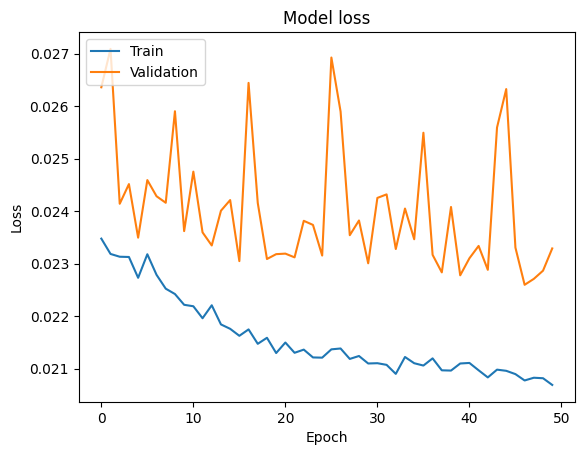

In [277]:
# Plot loss (ignore first epoch)
plt.plot(history.history['loss'][-50:])
plt.plot(history.history['val_loss'][-50:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Model Exploration: DNN (Windowed)

In [ ]:
# Create simple neural network
inputs = keras.Input(shape=(READINGS_PER_SAMPLE, len(X_cols)))
x1 = keras.layers.Flatten()(inputs)
x2 = keras.layers.Dense(16, activation="relu")(x1)
x3 = keras.layers.Dense(16, activation="relu")(x2)
output = keras.layers.Dense(1)(x3)
model = keras.Model(inputs=inputs, outputs=output)

# Compile model
model.compile(optimizer="adam", loss="mean_squared_error")
model.to(device)
print(model.summary())


Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 5, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 16)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545 (2.13 KB)

 Trainable params: 545 (2.13 KB)

 Non-trainable params: 0 (0.00 B)

None


In [159]:
# Train model
history = model.fit(
    X_train_tensor, 
    y_train_tensor, 
    validation_data=(X_val_tensor, y_val_tensor), 
    epochs=100, 
    batch_size=128
)

Epoch 1/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 10572.4873 - val_loss: 14.0317
Epoch 2/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 10.8469 - val_loss: 6.1991
Epoch 3/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.9745 - val_loss: 3.2058
Epoch 4/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.1449 - val_loss: 2.2514
Epoch 5/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.1648 - val_loss: 1.7871
Epoch 6/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6522 - val_loss: 1.4477
Epoch 7/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.3353 - val_loss: 1.1024
Epoch 8/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1444 - val_loss: 0.8478
Epoch 9/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.8206 - val_loss: 0.5999
Epoch 10/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6557 - val_loss: 0.5238
Epoch 11/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.4923 - val_loss: 0.3762
Epoch 12/100
552/552 ━━━━━━━━━━━━━━

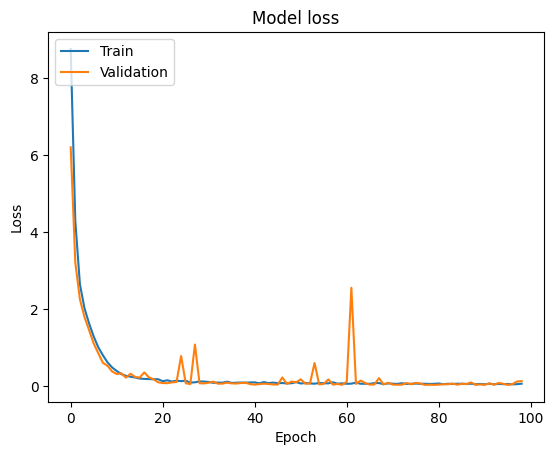

In [ ]:
# Plot loss (ignore first epoch)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()